In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from fis_cleaning_functions import *

In [2]:
with open("data/fis_dataframe.pkl","rb") as picklefile:
    df = pickle.load(picklefile)

## Cleaning

In [3]:
# drop_duplicates was called before pickeling
if len(df) != df.index[-1]:
    df.reset_index(inplace=True)
print("Length equals last index:",len(df)==df.index[-1]+1)

Length equals last index: True


In [4]:
df["datetime"]= pd.to_datetime(df["date"])
df["season"] = df["datetime"].transform(get_season)
df.rename(axis=1, mapper={"ladies":"gender:ladies"}, inplace=True)

first_days = df.groupby("season")["datetime"].min()
df["days_since_season_start"] = [get_day_of_season(date, first_days) for date in df["datetime"]]

df["ski_field"]=df["location"].transform(standardize_location)
df["region"]=[get_region(field) for field in df["ski_field"]]

# Cheating: stealing from the future. but may be interesting.
df["median_finish_time"]=df["finish_times"].transform(lambda x: x[int(len(x)/2)])
df["normalized_times"]=df["finish_times"].transform(np.array)/df["median_finish_time"]
df["normalized_time_stdev"]=[np.std(row["normalized_times"]) for _, row in df.iterrows()]


df["log_dnf_rate"] = df["dnf_rate"].transform(lambda x: np.log(x+np.e**-5.5))
df["sqrt_dnf_rate"] = df["dnf_rate"].transform(lambda x: np.sqrt(x))
df["olympics"] = [is_olympics(row) for _, row in df.iterrows()]

In [5]:
if "index" in df.columns:
    df.drop("index", axis=1, inplace=True)
df.head()

,dnf_rate,location,gender:ladies,event,date,finish_times,datetime,season,days_since_season_start,ski_field,region,median_finish_time,normalized_times,normalized_time_stdev,log_dnf_rate,sqrt_dnf_rate,olympics
0,0.043478,Are (SWE),True,Slalom,17 March 2018,"[106.42, 108.0, 108.00999999999999, 108.14, 10...",2018-03-17,2018,140,Are (SWE),NEUTRAL,109.36,"[0.9731163130943673, 0.9875640087783467, 0.987...",0.013171,-3.045657,0.208514,False
1,0.086957,Are (SWE),False,Giant Slalom,17 March 2018,"[133.63, 133.86, 133.89, 134.31, 134.73, 135.2...",2018-03-17,2018,140,Are (SWE),NEUTRAL,135.74,"[0.9844555768380727, 0.9861499926329749, 0.986...",0.008364,-2.396420,0.294884,False
2,0.106383,Are (SWE),True,Super G,15 March 2018,"[67.92, 68.24, 68.45, 68.67, 68.85, 69.0, 69.0...",2018-03-15,2018,138,Are (SWE),NEUTRAL,69.42,"[0.9783923941227312, 0.9830020167098817, 0.986...",0.008501,-2.203014,0.326164,False
3,0.000000,Are (SWE),False,Super G,15 March 2018,"[49.43, 49.47, 49.51, 49.51, 49.58, 49.62, 49....",2018-03-15,2018,138,Are (SWE),NEUTRAL,49.89,"[0.9907797153738224, 0.9915814792543596, 0.992...",0.007044,-5.500000,0.000000,False
4,0.020408,Are (SWE),False,Downhill,14 March 2018,"[80.21000000000001, 80.21000000000001, 80.25, ...",2018-03-14,2018,137,Are (SWE),NEUTRAL,80.91,"[0.9913484118155977, 0.9913484118155977, 0.991...",0.005759,-3.709289,0.142857,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 17 columns):
dnf_rate                   737 non-null float64
location                   737 non-null object
gender:ladies              737 non-null bool
event                      737 non-null object
date                       737 non-null object
finish_times               737 non-null object
datetime                   737 non-null datetime64[ns]
season                     737 non-null int64
days_since_season_start    737 non-null int64
ski_field                  737 non-null object
region                     737 non-null object
median_finish_time         737 non-null float64
normalized_times           737 non-null object
normalized_time_stdev      737 non-null float64
log_dnf_rate               737 non-null float64
sqrt_dnf_rate              737 non-null float64
olympics                   737 non-null bool
dtypes: bool(2), datetime64[ns](1), float64(5), int64(2), object(7)
memory usage: 87.9+ K

In [7]:
df.season.value_counts()

2011    87
2017    84
2012    83
2013    82
2010    82
2016    80
2015    80
2014    80
2018    79
Name: season, dtype: int64

In [8]:
event_dummies = pd.get_dummies(df["event"], drop_first=True)
event_dummies.rename(lambda s: "event:"+s, axis=1, inplace=True)

region_dummies = pd.get_dummies(df["region"], drop_first=True)
region_dummies.rename(lambda s: "region:"+s, axis=1, inplace=True)

dummied_df = df.join(event_dummies).join(region_dummies)

## Correlations

In [9]:
dummied_df.corr()

,dnf_rate,gender:ladies,season,days_since_season_start,median_finish_time,normalized_time_stdev,log_dnf_rate,sqrt_dnf_rate,olympics,event:Downhill,...,event:Super G,region:BUL,region:CAN,region:FRA,region:GER,region:ITA,region:KOR,region:NEUTRAL,region:NOR,region:SE_ALPS
dnf_rate,1.000000,-0.127563,0.024339,-0.150628,0.286839,0.161316,0.854186,0.958025,-0.026058,-0.562793,...,-0.218931,-0.044759,-0.218057,-0.035917,-0.053886,-0.077535,-0.064810,0.036532,-0.144073,0.297075
gender:ladies,-0.127563,1.000000,0.023228,-0.018580,-0.175880,-0.062313,-0.072118,-0.099640,0.012146,-0.041544,...,0.060233,-0.011468,0.069757,0.007953,0.053809,-0.029455,0.003589,0.001566,-0.170946,-0.004295
season,0.024339,0.023228,1.000000,-0.012940,-0.145572,-0.013376,0.058916,0.044495,-0.006854,0.004762,...,0.025938,-0.058019,-0.096407,0.004693,-0.095518,0.040279,0.194312,0.071761,-0.003498,-0.042646
days_since_season_start,-0.150628,-0.018580,-0.012940,1.000000,-0.090779,0.179831,-0.126659,-0.145795,0.159697,0.032743,...,0.056155,0.100955,-0.242586,-0.106569,0.230730,-0.125774,0.101911,0.037354,0.211473,-0.022790
median_finish_time,0.286839,-0.175880,-0.145572,-0.090779,1.000000,0.036304,0.309156,0.313485,0.032202,-0.148137,...,-0.568626,-0.035399,-0.102876,-0.020883,0.021933,-0.051360,-0.052820,0.033004,-0.103744,0.142405
normalized_time_stdev,0.161316,-0.062313,-0.013376,0.179831,0.036304,1.000000,0.123859,0.144319,0.138620,-0.139290,...,-0.062384,-0.013331,-0.024012,-0.059154,0.094568,-0.080750,0.061156,0.049070,-0.055118,0.007706
log_dnf_rate,0.854186,-0.072118,0.058916,-0.126659,0.309156,0.123859,1.000000,0.966750,-0.059381,-0.575886,...,-0.135596,-0.062681,-0.198280,-0.069628,0.013988,-0.048836,-0.103080,0.038620,-0.092039,0.239753
sqrt_dnf_rate,0.958025,-0.099640,0.044495,-0.145795,0.313485,0.144319,0.966750,1.000000,-0.043561,-0.596730,...,-0.181347,-0.055854,-0.218277,-0.055991,-0.018938,-0.065877,-0.087592,0.042889,-0.125202,0.276710
olympics,-0.026058,0.012146,-0.006854,0.159697,0.032202,0.138620,-0.059381,-0.043561,1.000000,0.041303,...,-0.011674,-0.021201,0.216078,-0.066766,-0.061484,-0.077130,0.450480,0.008654,-0.037978,-0.123078
event:Downhill,-0.562793,-0.041544,0.004762,0.032743,-0.148137,-0.139290,-0.575886,-0.596730,0.041303,1.000000,...,-0.313796,-0.060787,0.174072,0.034390,0.054175,0.094955,0.046712,-0.080608,0.104639,-0.176680


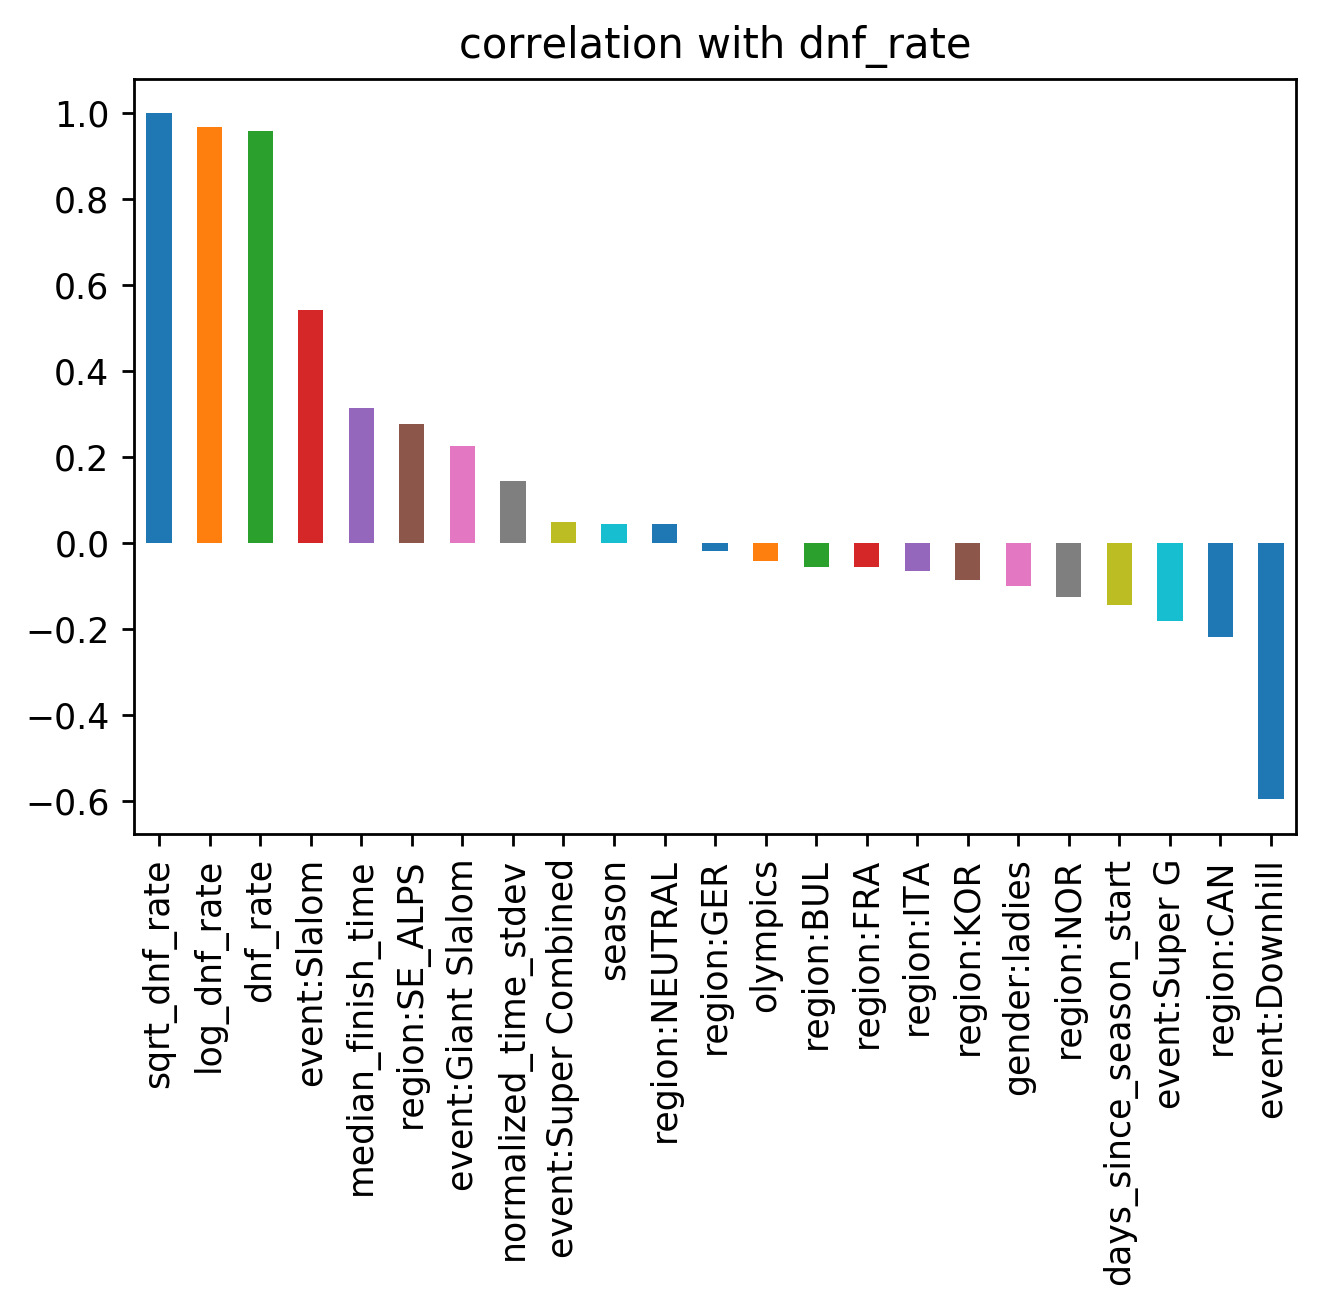

In [10]:
plt.figure(dpi=250)
dummied_df.corr()["sqrt_dnf_rate"].sort_values(ascending=False).plot(kind="bar")
plt.title("correlation with dnf_rate");

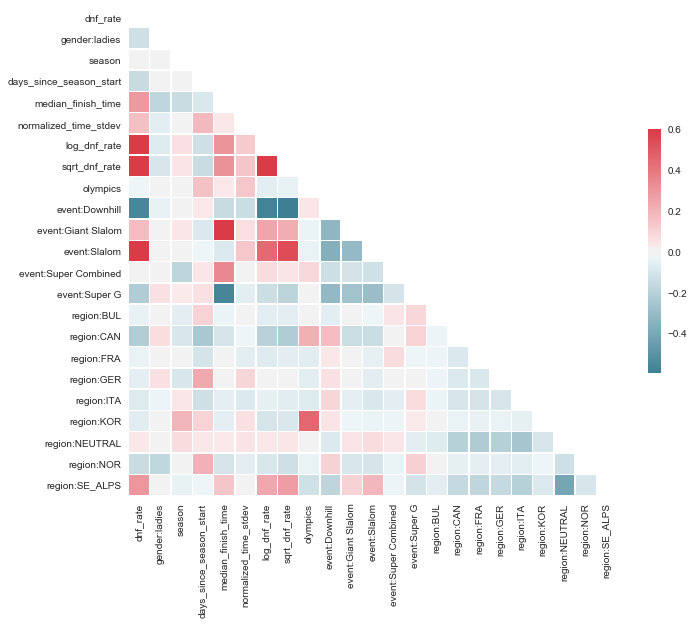

In [11]:
sns.set(style="white")


# Compute the correlation matrix
corr = dummied_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Separate validation data

Manually write a `test_train_split` ~~because you can't find the real one~~ for random-state reproducibility.

(turns out, works well for separating my supertesting set)

In [12]:
shuffled_df = dummied_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_thresh = int(0.2*len(shuffled_df))
supertest_df = shuffled_df.iloc[:test_thresh]
train_df = shuffled_df.iloc[test_thresh:]

#print("Testing samples:",len(test_df),"\nTraining samples:",len(train_df))

In [13]:
import pickle
import time

with open("data/test_df_{}.pkl".format(time.strftime("%Y%m%d-%H%M")), "wb") as picklefile:
    pickle.dump(supertest_df, picklefile)

with open("data/train_df_{}.pkl".format(time.strftime("%Y%m%d-%H%M")), "wb") as picklefile:
    pickle.dump(train_df, picklefile)
print(time.strftime("%Y%m%d-%H%M"))


20180427-1454


## Finish time analysis (Not used, may or may not still work)

In [14]:
df["finish_times"]=df["finish_times"].transform(np.array)

In [15]:
df["med_finish"]=df["finish_times"].transform(lambda x: x[int(len(x)/2)])

In [16]:
df["normalized_times"]=df["finish_times"]/df["med_finish"]

(0.9, 1.0)

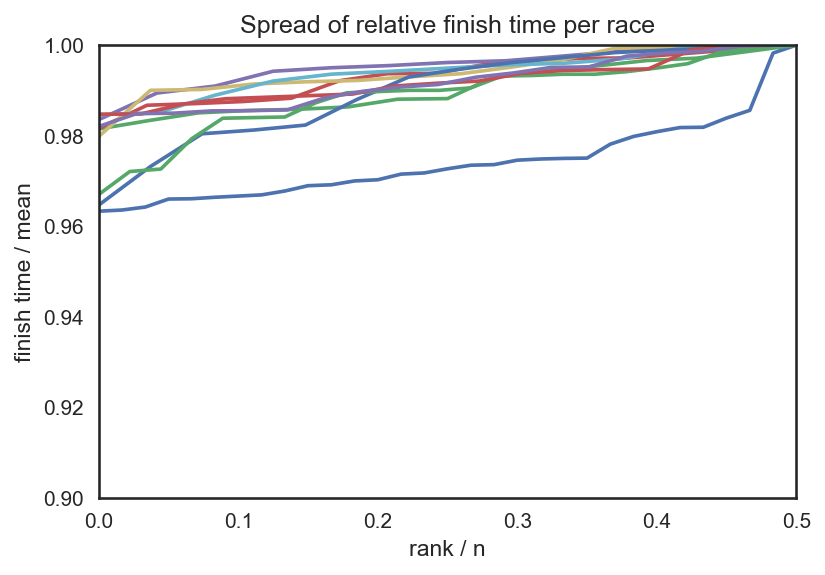

In [18]:
plt.figure(dpi=150)
for _, race in df.sample(n=10, random_state=42).iterrows():
    n = len(race["normalized_times"])
    xs = [i/n for i in range(n)]
    ys = race["normalized_times"]
    plt.plot(xs,ys)
plt.xlabel("rank / n")
plt.ylabel("finish time / mean")
plt.title("Spread of relative finish time per race")
plt.xlim(0,0.5)
plt.ylim(0.9,1.0)

In [19]:
df.normalized_times.head()
#plt.hist([1,1,1,1,1,3,2,3,2,3,4,2,2,3,2,1,3,1,4]);

0    [0.9731163130943673, 0.9875640087783467, 0.987...
1    [0.9844555768380727, 0.9861499926329749, 0.986...
2    [0.9783923941227312, 0.9830020167098817, 0.986...
3    [0.9907797153738224, 0.9915814792543596, 0.992...
4    [0.9913484118155977, 0.9913484118155977, 0.991...
Name: normalized_times, dtype: object

In [20]:
df.normalized_times.transform(pd.Series).head()

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,0.973116,0.987564,0.987655,0.988844,0.989484,0.991313,0.991862,0.992776,0.993142,0.993233,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.984456,0.986150,0.986371,0.989465,0.992559,0.996095,0.996243,0.999632,0.999705,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.978392,0.983002,0.986027,0.989196,0.991789,0.993950,0.994958,0.995678,0.996255,0.999136,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.990780,0.991581,0.992383,0.992383,0.993786,0.994588,0.995390,0.998196,0.999198,0.999399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.991348,0.991348,0.991843,0.992832,0.994315,0.995056,0.995303,0.996539,0.996663,0.996787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
for k in sorted(list(set(df["season"].values))):
    print(k,df["season"].value_counts()[k])

2010 82
2011 87
2012 83
2013 82
2014 80
2015 80
2016 80
2017 84
2018 79


In [24]:
df["field_mean"] = df.groupby(["gender:ladies", "location", "event"])["med_finish"].head()

In [25]:
len(df[df["field_mean"] != df["med_finish"]])

139

Text(0.5,1,'dnf rate by country')

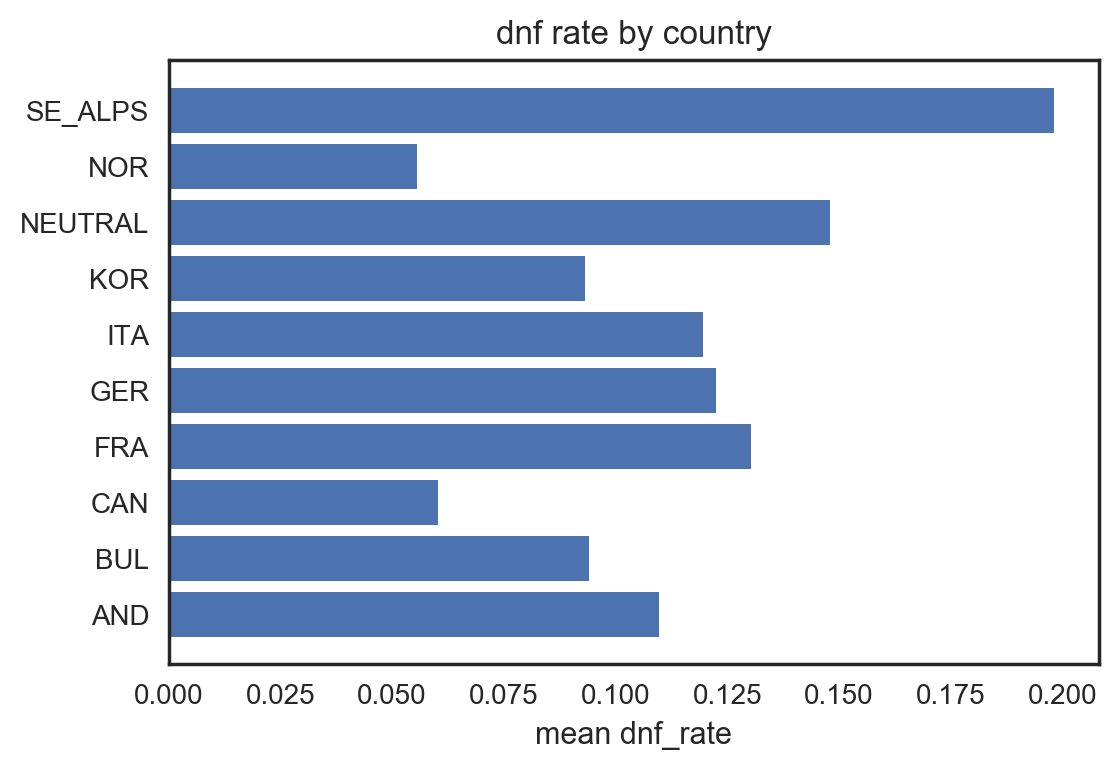

In [26]:

region_dnfs = df.groupby("region")["dnf_rate"].mean()
plt.figure(dpi=200)
plt.barh(region_dnfs.index, region_dnfs.values)
plt.xlabel("mean dnf_rate")
plt.title("dnf rate by country")